# Home task: Kaggle Competition [Titanic - Machine Learning from Disaster](https://www.kaggle.com/c/titanic)

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
%matplotlib inline

In [3]:
CWD = os.getcwd()
DATA_DIR = os.path.join(CWD, 'titanic_data')
TRAIN_FILE = os.path.join(DATA_DIR, 'train.csv')
TEST_FILE = os.path.join(DATA_DIR, 'test.csv')

### Exploratory Data Analysis (EDA)

In [4]:
# Load train dataset
train_data = pd.read_csv(TRAIN_FILE)
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In the train dataset we have 12 columns:
 - `PassengerId` - passenger id
 - `Survived` - survival (0 = No, 1 = Yes)
 - `Pclass` - ticket class (1 = 1st, 2 = 2nd, 3 = 3rd): a proxy for socio-economic status (1st = upper, 2nd = middle, 3rd = lower)
 - `Name` - passenger name
 - `Sex` - passenger sex
 - `Age` - passenger age in years: age is fractional if less than 1; if age is estimated, is it in the form of xx.5
 - `SibSp` - number of siblings/spouses aboard the Titanic: sibling = brother, sister, stepbrother, stepsister; spouse = husband, wife (mistresses and fiancés were ignored)
 - `Parch` - number of parents/children aboard the Titanic: parent = mother, father; child = daughter, son, stepdaughter, stepson; some children travelled only with a nanny, therefore parch = 0 for them
 - `Ticket` - ticket number
 - `Fare` - passenger fare
 - `Cabin` - cabin number
 - `Embarked` - port of embarkation	(C = Cherbourg, Q = Queenstown, S = Southampton)

Columns `PassengerId`, `Name`, `Ticket` and `Cabin` are irrelevent for prediction whether the passenger were survived, so we will ignore them.

Now let's build the plots of column values depending on whether the passenger were survived.

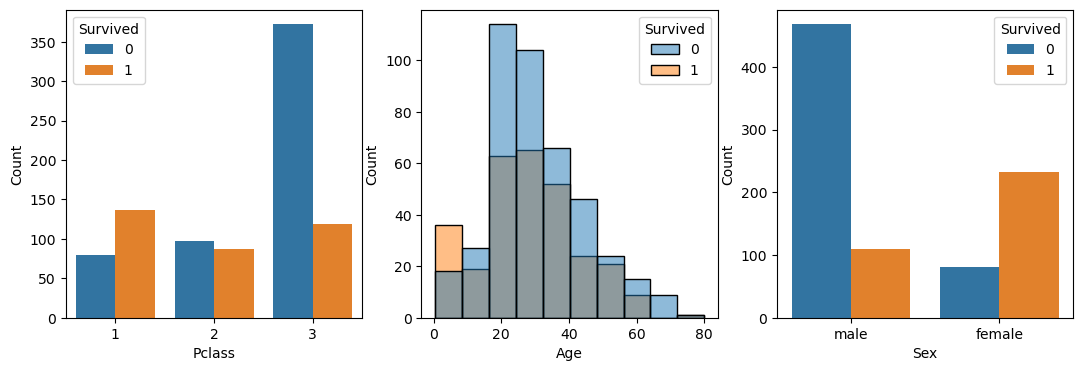

In [5]:
plt.figure(figsize=(13, 4))

# Bar chart of Pclass column depending on passenger survival
plt.subplot(1, 3, 1, ylabel='Count')
sns.countplot(train_data, x='Pclass', hue='Survived')

# Histogram of Age column depending on passenger survival
plt.subplot(1, 3, 2)
sns.histplot(train_data, x='Age', hue='Survived', bins=10)

# Bar chart of Sex column depending on passenger survival
plt.subplot(1, 3, 3, ylabel='Count')
sns.countplot(train_data, x='Sex', hue='Survived');

The first plot (`Pclass` column) shows us that the higher the ticket class (from 3rd to 1st), the higher the survival rate. In the 1st class number of passengers who survived higher than the number of passengers who did not survived.

In the second plot (`Age` column) we can see that survival rate is low among adult passengers. However, most child passengers under the age of 10 were survived.

The third plot (`Sex` column) shows that the survival rate among female passengers is higher than male passengers.

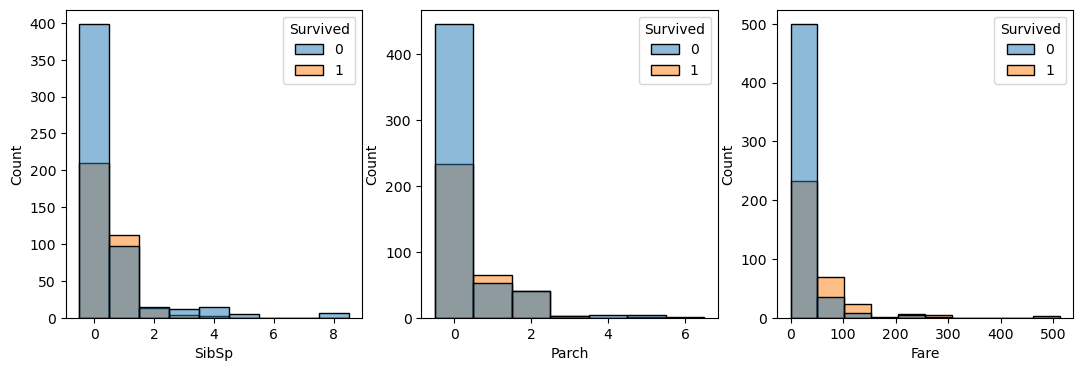

In [6]:
plt.figure(figsize=(13, 4))

# Histogram of SibSp column depending on passenger survival
plt.subplot(1, 3, 1)
sns.histplot(train_data, x='SibSp', hue='Survived', discrete=True)

# Histogram of Parch column depending on passenger survival
plt.subplot(1, 3, 2)
sns.histplot(train_data, x='Parch', hue='Survived', discrete=True)

# Histogram of Fare column depending on passenger survival
plt.subplot(1, 3, 3)
sns.histplot(train_data, x='Fare', hue='Survived', bins=10);

In the first and second plots (columns `SibSp` and `Parch`) we can see that number of siblings/spouses or parents/children aboard does not affect the survival ratio. However, it is worth noting that for passengers who had one sibling/spouse or parent/child aboard survival ratio is higher.

The third plot (`Fare` column) shows us that the survival ratio is higher among passengers who have paid between 50 and 150.

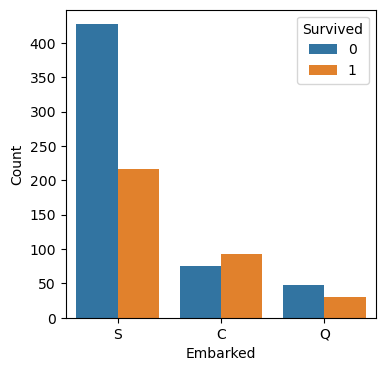

In [7]:
# Bar chart of Embarked column depending on passenger survival
plt.figure(figsize=(4, 4))
plt.ylabel('Count')
sns.countplot(train_data, x='Embarked', hue='Survived');

This plot shows that the survival ratio is the highest among passengers who have embarked from Cherbourg.

### Data Cleaning

Before we start cleaning the data, we need to analyze the data types in different columns determine if there are NA values in the dataset.

In [8]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [9]:
train_data.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

So, `Age` column has 177 NA values and `Embarked` column has 2 NA values (`Cabin` column is ignored). For further forecasting we need fill in the NA values in these columns with the aggregated values from dataset.

Let's create a new column which contains passenger initials (honorifics): Mr, Miss, Mrs, Sir, Lady etc.

In [10]:
initials = train_data['Name'].str.extract('(\w+)\.').squeeze()
initials.unique()

array(['Mr', 'Mrs', 'Miss', 'Master', 'Don', 'Rev', 'Dr', 'Mme', 'Ms',
       'Major', 'Lady', 'Sir', 'Mlle', 'Col', 'Capt', 'Countess',
       'Jonkheer'], dtype=object)

Now, we reduce the number of possible passenger initials.

In [11]:
initials.replace(
    ['Mlle', 'Mme', 'Ms'] +                  # To Miss
    ['Lady', 'Countess'] +                   # To Mrs
    ['Dr', 'Major', 'Capt', 'Sir', 'Don'] +  # To Mr
    ['Jonkheer', 'Col', 'Rev'],              # To Other
    ['Miss'] * 3 + ['Mrs'] * 2 + ['Mr'] * 5 + ['Other'] * 3,
    inplace=True
)
initials.unique()

array(['Mr', 'Mrs', 'Miss', 'Master', 'Other'], dtype=object)

Then we can fill in the NA values in `Age` column with the age mean values for different passenger initials.

In [12]:
# Age mean values for different passenger initials (estimation can be xx.0 or xx.5)
age_means = train_data.groupby(initials)['Age'].mean().round(1)
age_means - (age_means % 0.5)

0
Master     4.5
Miss      21.5
Mr        32.5
Mrs       36.0
Other     45.5
Name: Age, dtype: float64

We can fill in the NA values in `Embarked` column with the most common value in this column.

In [13]:
# Most common embarkation value (mode)
train_data['Embarked'].value_counts().index[0]

'S'

Now, we investigate the test dataset.

In [14]:
# Load test dataset
test_data = pd.read_csv(TEST_FILE)
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.1+ KB


Here we will also determine if the dataset contains NA values.

In [15]:
test_data.isna().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

In the test dataset `Age` column has 86 NA values and `Fare` column has one NA value.

To fill in the NA values in `Age` column, we follow the same process.

In [16]:
initials = test_data['Name'].str.extract('(\w+)\.').squeeze()
initials.unique()

array(['Mr', 'Mrs', 'Miss', 'Master', 'Ms', 'Col', 'Rev', 'Dr', 'Dona'],
      dtype=object)

In [17]:
initials.replace(
    ['Ms'] +            # To Miss
    ['Lady', 'Dona'] +  # To Mrs
    ['Dr'] +            # To Mr
    ['Col', 'Rev'],     # To Other
    ['Miss'] + ['Mrs'] * 2 + ['Mr'] + ['Other'] * 2,
    inplace=True
)
initials.unique()

array(['Mr', 'Mrs', 'Miss', 'Master', 'Other'], dtype=object)

In [18]:
# Age mean values for different passenger initials (estimation can be xx.0 or xx.5)
age_means = test_data.groupby(initials)['Age'].mean().round(1)
age_means - (age_means % 0.5)

0
Master     7.0
Miss      21.5
Mr        32.0
Mrs       38.5
Other     42.5
Name: Age, dtype: float64

To fill in the NA values in `Fare` column, we can use the average value in this column.

In [19]:
# Average fare value
test_data['Fare'].mean()

35.627188489208635

To be able to apply cleaning process to train and test dataset, we create clean_titanic_data function.

In [20]:
def clean_titanic_data(data, return_y=True):
    '''
    Performs data cleaning in titanic dataset.

    :param data: A dataset
    :type data: DataFrame
    :param return_y: If `True`, returns `(ids, X, y)`, if `False`, returns `(ids, X)`
    :type return_y: bool

    :raises TypeError: Occurs if `data` does not contain `Survived` column when `return_y=True`

    :return: `(ids, X, y)` or `(ids, X)` where `ids` is passenger ids, ndarray of shape (?,),
    `X` is features values, ndarray of shape (?, n), `y` is target values, ndarray of shape (?,)
    :rtype: tuple[ndarray, ndarray, ndarray] | tuple[ndarray, ndarray]
    '''
    
    # Copy the dataset
    titanic = data.copy()

    # Create columns of passenger initials (honorifics)
    titanic['Initial'] = titanic['Name'].str.extract('(\w+)\.')
    titanic['Initial'] = titanic['Initial'].replace(
        ['Mlle', 'Mme', 'Ms'] +                  # Replace to Miss
        ['Lady', 'Countess', 'Dona'] +           # Replace to Mrs
        ['Dr', 'Major', 'Capt', 'Sir', 'Don'] +  # Replace to Mr
        ['Jonkheer', 'Col', 'Rev'],              # Replace to Other
        ['Miss'] * 3 + ['Mrs'] * 3 + ['Mr'] * 5 + ['Other'] * 3
    )

    # Fill in NA values in Age column with age mean values for different passenger initials
    age_means = titanic.groupby('Initial')['Age'].mean().round(1)
    age_means -= age_means % 0.5
    titanic.loc[data['Age'].isna(), 'Age'] = titanic.loc[data['Age'].isna(), 'Initial'].map(age_means.to_dict())

    # Fill in NA values in Fare column with fare average value
    fare_mean = titanic['Fare'].mean()
    titanic['Fare'] = titanic['Fare'].fillna(fare_mean)

    # Fill in NA values in Embarked column with embarkation mode value
    embarkation_mode = titanic['Embarked'].value_counts().index[0]
    titanic['Embarked'] = titanic['Embarked'].fillna(embarkation_mode)

    # Convert values in Sex column to numeric
    titanic['Sex'] = titanic['Sex'].map({'male': 0, 'female': 1})

    # Create dummy features which represent unique values in Embarked column
    embarkations = pd.get_dummies(titanic['Embarked'], prefix='Embarked', dtype='int')
    titanic = pd.concat([titanic, embarkations], axis=1)

    # Name of passenger id column
    id_feature = 'PassengerId'

    # Names of feature columns and target column
    features = ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare'] + embarkations.columns.to_list()
    target = 'Survived'

    # Return ids values, feature values and target values
    if return_y:
        if target not in titanic.columns:
            raise TypeError(f'Dataset does not contain a {target} column')
        return titanic[id_feature].values, titanic[features].values, titanic[target].values
    
    # Return only ids values and feature values
    else:
        return titanic[id_feature].values, titanic[features].values

### ML Models Building

In [21]:
# Clean train dataset
_, X_train, y_train = clean_titanic_data(train_data, return_y=True)
print(f'Shape of features: {X_train.shape}')
print(f'Shape of targets: {y_train.shape}')

Shape of features: (891, 9)
Shape of targets: (891,)


In [22]:
from sklearn.preprocessing import MinMaxScaler

# Normalize train dataset using min-max scaling
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)

In [23]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression 
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier

from sklearn.model_selection import GridSearchCV

#### K-Nearest Neighbors (KNeighborsClassifier)

In [24]:
# Build k-nearest neighbors model and find optimal parameters
clf = KNeighborsClassifier()
params = {'n_neighbors': list(range(3, 20))}
grid_clf = GridSearchCV(clf, params).fit(X_train_scaled, y_train)

print('Best parameters (KNeighborsClassifier):', grid_clf.best_params_)
print('Best score (accuracy):', grid_clf.best_score_)

Best parameters (KNeighborsClassifier): {'n_neighbors': 9}
Best score (accuracy): 0.8080660347749671


#### Logistic Regression (LogisticRegression)

In [25]:
# Build logistic regression model and find optimal parameters
clf = LogisticRegression()
params = {'C': [0.001, 0.005, 0.01, 0.05, 0.1, 0.2, 0.5, 1, 2, 5, 10]}
grid_clf = GridSearchCV(clf, params).fit(X_train_scaled, y_train)

print('Best parameters (LogisticRegression):', grid_clf.best_params_)
print('Best score (accuracy):', grid_clf.best_score_)

Best parameters (LogisticRegression): {'C': 0.5}
Best score (accuracy): 0.7923733601154981


#### Support Vector Machine (SVC)

In [26]:
# Build SVM model and find optimal parameters
clf = SVC(kernel='rbf')
params = {
    'C': [0.001, 0.005, 0.01, 0.05, 0.1, 0.2, 0.5, 1, 2, 5, 10],
    'gamma': [0.001, 0.01, 0.05, 0.1, 0.5, 1, 10, 50]
}
grid_clf = GridSearchCV(clf, params).fit(X_train_scaled, y_train)

print('Best parameters (SVC):', grid_clf.best_params_)
print('Best score (accuracy):', grid_clf.best_score_)

Best parameters (SVC): {'C': 5, 'gamma': 1}
Best score (accuracy): 0.8226727763480006


#### Decision Tree Algorithm

In [27]:
# Build decision tree model and find optimal parameters
clf = DecisionTreeClassifier(random_state=2023)
params = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [2, 5, 7, 10, 20, 30, 35, 40, 50]
}
grid_clf = GridSearchCV(clf, params).fit(X_train_scaled, y_train)

print('Best parameters (DecisionTreeClassifier):', grid_clf.best_params_)
print('Best score (accuracy):', grid_clf.best_score_)

Best parameters (DecisionTreeClassifier): {'criterion': 'entropy', 'max_depth': 5}
Best score (accuracy): 0.818172117255665


#### Random Forest Algorithm

In [28]:
# Build random forest model and find optimal parameters
clf = RandomForestClassifier(random_state=2023)
params = {
    'criterion': ['gini', 'entropy', 'log_loss'],
    'n_estimators': [20, 50, 100, 150, 200, 250, 300]
}
grid_clf = GridSearchCV(clf, params).fit(X_train_scaled, y_train)

print('Best parameters (RandomForestClassifier):', grid_clf.best_params_)
print('Best score (accuracy):', grid_clf.best_score_)

Best parameters (RandomForestClassifier): {'criterion': 'entropy', 'n_estimators': 300}
Best score (accuracy): 0.815956311593748


#### Gradient Boosting Decision Trees Algorithm

In [29]:
# Build gradient boosting decision trees model and find optimal parameters
clf = GradientBoostingClassifier(random_state=2023)
params = {
    'learning_rate': [0.01, 0.02, 0.05, 0.1, 0.2, 0.5, 1, 2, 5, 10],
    'n_estimators': [20, 50, 100, 150, 200, 250, 300]
}
grid_clf = GridSearchCV(clf, params).fit(X_train_scaled, y_train)

print('Best parameters (GradientBoostingClassifier):', grid_clf.best_params_)
print('Best score (accuracy):', grid_clf.best_score_)

Best parameters (GradientBoostingClassifier): {'learning_rate': 0.1, 'n_estimators': 300}
Best score (accuracy): 0.8372732408511705


So, the best classifier is the Gradient Boosting Decision Trees model (GradientBoostingClassifier) with accuracy score equal to 0.8372732408511705.

In [30]:
# Find the gradient boosting decision trees models again
grid = GridSearchCV(
    GradientBoostingClassifier(random_state=2023),
    {'learning_rate': [0.01, 0.02, 0.05, 0.1, 0.2, 0.5, 1, 2, 5, 10], 'n_estimators': [20, 50, 100, 150, 200, 250, 300]}
).fit(X_train_scaled, y_train)

# The best classifier
model = grid.best_estimator_
model

GradientBoostingClassifier(n_estimators=300, random_state=2023)

### Predict test dataset using the best model

In [32]:
# Clean test dataset
passenger_ids, X_test = clean_titanic_data(test_data, return_y=False)
print(f'Shape of passenger ids: {passenger_ids.shape}')
print(f'Shape of features: {X_test.shape}')

Shape of passenger ids: (418,)
Shape of features: (418, 9)


In [33]:
# Normalize test dataset using min-max scaling
scaler = MinMaxScaler()
X_test_scaled = scaler.fit_transform(X_test)

In [35]:
# Compute the target predictions for test dataset 
predictions = model.predict(X_test_scaled)
print(f'Shape of predictions: {predictions.shape}')

Shape of predictions: (418,)


### Submit predictions to Kaggle Competition

In [38]:
# Merge passenger ids and target predictions, and save them to a CSV file
submition_data = np.hstack([passenger_ids.reshape(-1, 1), predictions.reshape(-1, 1)])
pd.DataFrame(submition_data, columns=['PassengerId', 'Survived']).to_csv('submition.csv', index=False)

#### Kaggle submition score

![image](kaggle_submit.png)